# Neural Networks - Architecture & Parameters


## Agenda

- Overview of a few Neural Network types and parameters
- Code example: Feed Forward NN with Keras
- Code example: RNN (LSTM) with Keras
- Exercise: Parameter tuning to optimize an image recognizer


## A zoo of networks - which one to choose?

A detailed overview of different architecture types can be found here:  
http://www.asimovinstitute.org/neural-network-zoo/   


Different tasks require different types of networks.
EXAMPLES:

### Simple Classification tasks - Basic Feedforward NN

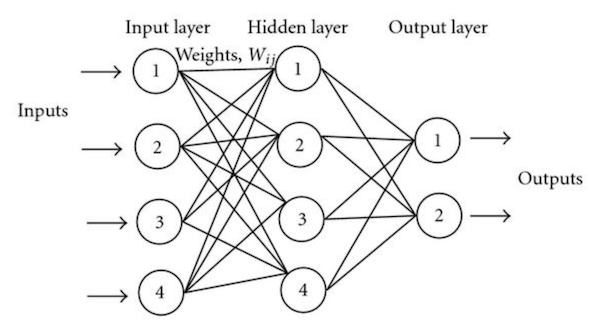



### Sequential Data problems (e.g. text analysis) - Recurrent Neural Networks (RNNs)

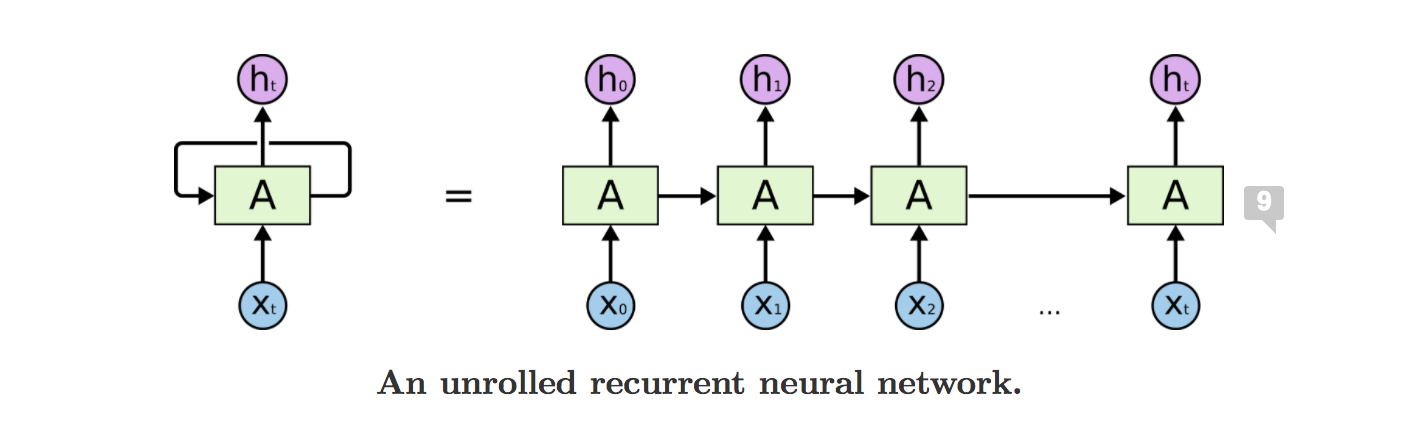
(Source: https://colah.github.io/posts/2015-08-Understanding-LSTMs/)




### Image Recognition - Convolutional Neural Networks (CNN)

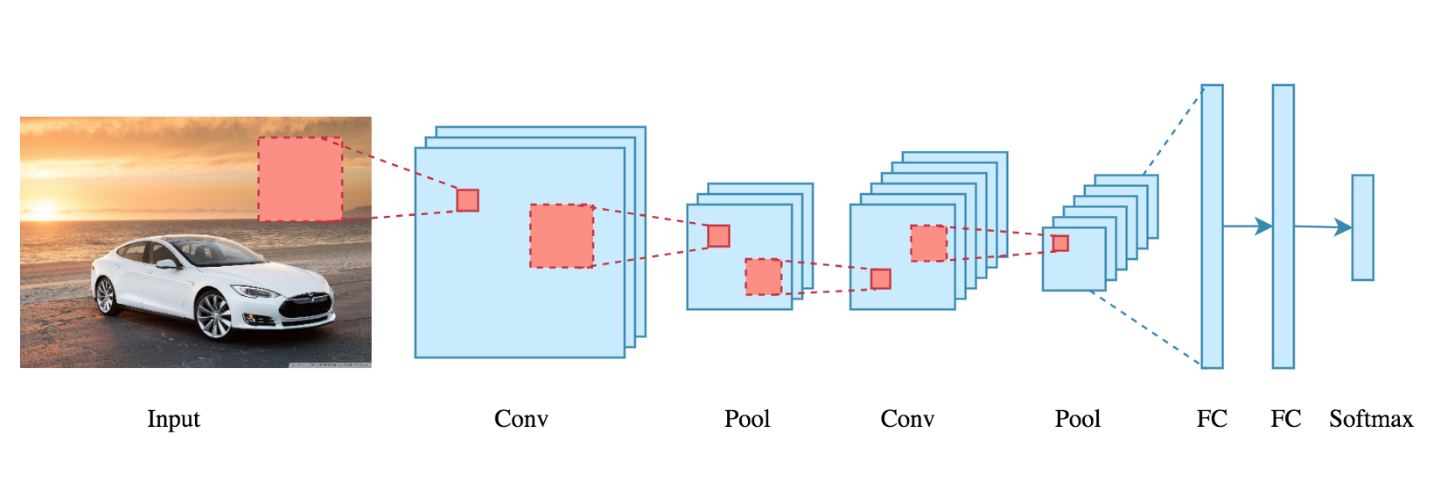
(Source: https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2)






## What Parameters to look out for?

### Optimizer Parameters
These parameters are related to the optimization and training process of your model

- Learning rate (very important!)
- Training batch size
- Training epochs (iterations)
- Optimizer
- Momentum
- Weights and biases

### Model Parameters
These parameters are related to the structure of your model

- How many layers? (depth)  
- How many units? (width)  
- How are they interconnected? 
- Dropout
- Activation function
- Loss function

#### Model-specific Parameters, e.g.:
- Filter size, Pooling (for CNNs) 
- RNN Cell time
- Word embedding dimensionality


### Finding the ideal architecture & Parameters for a task usually requires a good bit of experimentation!  






# A Feed Forward Neural Network using Keras

ToDo: For both this and the next section, give more examples for the different params we're going to look at

### Dataset: IMDB Reviews

1 = positive  
2 = negative

In [28]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import models, layers, utils, callbacks, optimizers
import numpy as np
import matplotlib.pyplot as plt

In [29]:
INDEX_FROM = 3
NUM_WORDS = 4000
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=NUM_WORDS,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=42,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=INDEX_FROM)


In [30]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in x_train[5] ))
print(y_train[5])
print(x_train[5])


MAXLEN = 120

X_train = sequence.pad_sequences(x_train, maxlen=MAXLEN)
X_test = sequence.pad_sequences(x_test, maxlen=MAXLEN)

Y_train = np.array(y_train)
Y_test = np.array(y_test)

print(X_train.shape)
print(Y_train.shape)

<START> this really is an incredible film not only does it <UNK> the <UNK> struggle of <UNK> and <UNK> people to gain their <UNK> voice but it also shows the united states up for its <UNK> <UNK> and <UNK> <UNK> for human rights and self <UNK> <UNK> is shown as a very brave and charismatic leader struggling against what can only be <UNK> as a <UNK> <UNK> <UNK> of any sense of <UNK> or justice these filmmakers have <UNK> a <UNK> unlike anything <UNK> before br br and in the cross <UNK> we see the usa once again pulling the <UNK> and <UNK> all sense of reality it's heart breaking to watch the initial <UNK> of the <UNK> knowing full well that the <UNK> of <UNK> that we're <UNK> is a <UNK> long used by <UNK> american <UNK> and their seemingly <UNK> <UNK> the footage makes it clear that this is not a <UNK> of tv or <UNK> footage but an <UNK> <UNK> of a people and its government fighting for its future truly a moving experience for anyone with a <UNK> these irish film makers deserve our <UNK>

In [31]:
# Paramters
# How many layers? (depth) -- let's start with one
# With most networks, usually not much value in using more than three layers (exception: Convolutionals)
# Number of units: just 'large enough'. Too many units can lead to overfitting.
num_units = 20

# How are they interconnected? -- Dense 'Feed Forward' network, output = activation(dot(input, kernel) + bias)
dropout_rate = 0.4
p_kernel_initializer = 'glorot_uniform' # this initializes the weights
p_use_bias = True  
p_bias_initializer = 'zeros'
activation_function_1 = 'relu'
activation_function_output = 'sigmoid'

p_learning_rate = 4
#p_learning_rate = 0.000001
#p_learning_rate = 0.001 # this is often a good default value to start with;
# Learning rate decay can be helpful, too!

p_optimizer_name = 'adam'
p_optimizer = optimizers.Adam(lr=p_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
# Momentum - configurable for some optmizers
loss_function = 'binary_crossentropy'

p_batch_size = 64
# larger batch sizes are computationally more efficient, but smaller batch sizes often train better

p_epochs = 4 # early stopping can be used, too

embedding_vector_length = 32

concat_params=str(num_units)+str(dropout_rate)+p_kernel_initializer+p_bias_initializer+activation_function_1+activation_function_output+str(p_learning_rate)+p_optimizer_name+loss_function+str(p_batch_size)+str(p_epochs)+str(embedding_vector_length)

print(concat_params)

200.4glorot_uniformzerosrelusigmoid4adambinary_crossentropy64432


In [32]:
tensor_board = callbacks.TensorBoard(log_dir='./Graph/' + concat_params, histogram_freq=0, write_graph=True, write_images=True)

# Start neural network
model = models.Sequential()

model.add(layers.Embedding(NUM_WORDS, embedding_vector_length, input_length=MAXLEN))
model.add(layers.SpatialDropout1D(dropout_rate))
model.add(layers.Flatten())

# Dense & Dropout layer
model.add(layers.Dense(
    num_units, 
    activation=activation_function_1,
    use_bias=p_use_bias, 
    kernel_initializer=p_kernel_initializer, 
    bias_initializer=p_bias_initializer))


model.add(layers.Dense(1, activation=activation_function_output))
# Compile the model
model.compile(loss=loss_function, optimizer=p_optimizer, metrics=['accuracy'])


# Train the model
model.fit(
    X_train, 
    Y_train, 
    validation_split=(0.2),
    epochs=p_epochs,
    batch_size=p_batch_size, 
    callbacks=[tensor_board]
)


Train on 20000 samples, validate on 5000 samples
Epoch 1/4
20000/20000 [==============================] - 2s 96us/step - loss: 8.0503 - acc: 0.4990 - val_loss: 7.9545 - val_acc: 0.5064
Epoch 2/4
20000/20000 [==============================] - 2s 95us/step - loss: 8.0906 - acc: 0.4980 - val_loss: 7.9545 - val_acc: 0.5064
Epoch 3/4
20000/20000 [==============================] - 2s 95us/step - loss: 8.0665 - acc: 0.4995 - val_loss: 7.9545 - val_acc: 0.5064
Epoch 4/4
20000/20000 [==============================] - 2s 87us/step - loss: 8.0890 - acc: 0.4980 - val_loss: 7.9545 - val_acc: 0.5064


In [42]:
model.evaluate(X_test, Y_test)

25000/25000 [==============================] - 1s 37us/step


[0.34821213881492613, 0.8518]

# A Recurrent Neural Network using Keras


### Dataset: IMDB Reviews   
1 = positive  
2 = negative

In [33]:
# create the model
# Model-Specific Parameter: Cell type; Here, we are using an 'LSTM' layer


embedding_vecor_length = 32
model = models.Sequential()
model.add(layers.Embedding(NUM_WORDS, embedding_vecor_length, input_length=MAXLEN, dropout=0.2))
model.add(layers.LSTM(30))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3, batch_size=32)


model.evaluate(X_test, Y_test)

/Users/heididuchting/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 120, 32)           128000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7560      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 31        
Total params: 135,591
Trainable params: 135,591
Non-trainable params: 0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 102s 4ms/step - loss: 0.4271 - acc: 0.7951 - val_loss: 0.3412 - val_acc: 0.8501
Epoch 2/3
25000/25000 [==============================] - 105s 4ms/step - loss: 0.2979 - acc: 0.8764 - val_loss: 0.3325 - val_acc: 0.8546
Epoch 3/3
25000/25000 [==============================] - 16s 625us/step

[0.38316090562343597, 0.84911999999999999]

# Parameter Tuning Competition


## Problem:  
We are using the 'Cifar10' dataset - aataset of 50,000 32x32 color training images, labeled over 10 categories, and 10,000 test images.  

We are trying to use the below basic Feed Forward Neural Network for this.    

It currently does not perform very well - can you find parameter values that would make it better?   

*Note*: Convolutional Neural Networks are usually more efficient and better suited for tasks like this. But let's start with this more basic approach for now, to get a feel for parameter tuning  

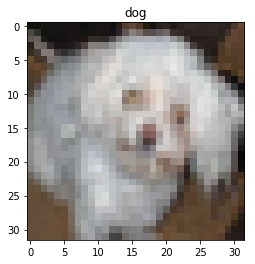

In [35]:
# Import libraries
from keras.datasets import cifar10  # or use mnist? Might be a bit easy, but better chances to get good results, and faster to train


# # Set random seed
np.random.seed(0)

img_labels = { 
    0: 'plane', 1: 'car', 2: 'bird',
    3: 'cat', 4: 'deer', 5: 'dog', 
    6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck' }
    

# Load data and target vector from Cifar image data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# x_train, x_test: uint8 array of RGB image data with shape (num_samples, 3, 32, 32).
# y_train, y_test: uint8 array of category labels (integers in range 0-9) with shape (num_samples,).


# Look at an example
sample_idx = 1000
img = x_test[sample_idx]
class_idx = y_test[sample_idx]

img = img.reshape((32,32,3))
plt.imshow(img)
plt.title(img_labels[class_idx[0]])
plt.show()


In [36]:
#x_train[sample_idx]
print('Single image shape: ', x_train[sample_idx].shape)
print('Shape of x_train: ', x_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of x_test: ', x_test.shape)
print('Shape of y_test: ', y_test.shape)
#print('Sample training input row: ', x_train[sample_idx])

Single image shape:  (32, 32, 3)
Shape of x_train:  (50000, 32, 32, 3)
Shape of y_train:  (50000, 1)
Shape of x_test:  (10000, 32, 32, 3)
Shape of y_test:  (10000, 1)


In [37]:
# Reshape
input_dim = 3072 # 32 * 32 * 3
X_train = x_train.reshape(50000, input_dim) 
X_test = x_test.reshape(10000, input_dim) 
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 
X_train /= 255 
X_test /= 255

# Labels to categorical
Y_train = utils.to_categorical(y_train, num_classes=10)
Y_test = utils.to_categorical(y_test, num_classes=10)


# Parameters
p_activation_1 = 'relu'
p_units_1 = 5
p_optimizer = 'sgd'
p_epochs = 2 
p_activation_2 = 'relu'
p_units_2 = 100
p_activation_out = 'softmax'
p_batch_size = 128


all_params = str(p_batch_size) + p_activation_1 + str(p_units_1) + p_optimizer + str(p_epochs) 


In [38]:
# Start neural network
model = models.Sequential()

# Add fully connected layer with a ReLU activation function
model.add(layers.Dense(
    units=p_units_1, 
    activation=p_activation_1, 
    input_shape=(input_dim,), 
    name="first_layer"))

# FEEL FREE TO ADD MORE LAYERS!
# model.add(layers.Dense(
#     units=p_units_2, 
#     activation=p_activation_2, 
#     name="second_layer"))

# Add fully connected layer with a sigmoid activation function
model.add(
    layers.Dense(
        units=10, 
        activation=p_activation_out, 
        name="output_layer"))


tb = callbacks.TensorBoard(log_dir='./Graph/' + all_params, histogram_freq=0, write_graph=True, write_images=True)

# Compile neural network model
model.compile(loss='categorical_crossentropy', 
              optimizer=p_optimizer, 
              metrics=['accuracy'])


# Train the model
model.fit(X_train, Y_train, epochs=p_epochs, batch_size=p_batch_size, callbacks=[tb])

Epoch 1/2
50000/50000 [==============================] - 1s 24us/step - loss: 2.2732 - acc: 0.1473
Epoch 2/2
50000/50000 [==============================] - 1s 21us/step - loss: 2.2145 - acc: 0.1656


In [39]:
# Evaluate the model
model.evaluate(X_test, Y_test)

10000/10000 [==============================] - 1s 52us/step


[2.1860289390563965, 0.17380000000000001]

In [40]:
# Try a test sample

print(X_test[sample_idx].reshape(1,3072).shape)
X_t = X_test[sample_idx].reshape(1,3072)
test_pred = model.predict_classes(X_t)
print("predicting: " + img_labels[test_pred[0]])

(1, 3072)
predicting: cat


# Useful Resources

- Deep Learning Online Courses (e.g. Coursera, or Udacity)
- 'Deep Learning Book' (http://www.deeplearningbook.org/)
- Curated Newsletters (e.g. https://odsc.com/, http://aidl.io/)
- Youtube Channels - e.g. Siraj Raval (e.g. https://www.youtube.com/watch?v=vOppzHpvTiQ)